## Let's create a dataset by downloading images from Bing

In [2]:
from bing_image_downloader import downloader

In [5]:
QUERIES = ["Slice Apple pie", 
           "Slice Strawberry Pie", 
           "Slice Apricots Pie", 
           "Slice Orange Pie", 
           "Slice Pumpkin Pie", 
           "Slice Pineapple Pie", 
           "Slice Cherry Pie",
           "Slice Carrot Pie",
           "Slice Banana Pie",
           "Slice Chocolate Pie"
           ]
OUTPUT_DIR = 'dataset_images'
NB_IMAGES = 50

for query in QUERIES:
    downloader.download(
        query, NB_IMAGES, OUTPUT_DIR,
        adult_filter_off=False, force_replace=False, timeout=15
    )

[%] Downloading Images to /Users/Sacha/HEIG/ARN05/dataset_images/Slice Apple pie


[!!]Indexing page: 1
[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://www.cubesnjuliennes.com/wp-content/uploads/2020/11/Apple-Pie-5.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.inspiredtaste.net/wp-content/uploads/2019/10/Homemade-Apple-Pie-Recipe-9-1200.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.jessicagavin.com/wp-content/uploads/2020/10/apple-pie-5-600x900.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://dinnerthendessert.com/wp-content/uploads/2019/09/Apple-Pie-2.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://ohsweetbasil.com/wp-content/uploads/classic-apple-pie-recipe-10-scaled.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://d2gg9evh47fn9z.cloudfront.net/1600px_COLOURBOX2828536.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://feelgoodfoodie.net/wp-content/uplo

### Generate a dataframe from the downloaded images

In [6]:
import os
import pandas as pd
from glob import glob

data = []

for label_dir in os.listdir(OUTPUT_DIR):
    if os.path.isfile(label_dir):
        continue
    
    label_path_path = os.path.join(OUTPUT_DIR, label_dir)
    for file in os.listdir(label_path_path):
        data.append([os.path.join(label_path_path, file), label_dir])
        
dataframe = pd.DataFrame(data, columns = ["path", "label"])
dataframe

,path,label
0,dataset_images/Slice Apricots Pie/Image_15.jpg,Slice Apricots Pie
1,dataset_images/Slice Apricots Pie/Image_29.jpg,Slice Apricots Pie
2,dataset_images/Slice Apricots Pie/Image_28.jpg,Slice Apricots Pie
3,dataset_images/Slice Apricots Pie/Image_14.jpg,Slice Apricots Pie
4,dataset_images/Slice Apricots Pie/Image_16.jpg,Slice Apricots Pie
...,...,...
496,dataset_images/Slice Banana Pie/Image_31.jpg,Slice Banana Pie
497,dataset_images/Slice Banana Pie/Image_25.jpg,Slice Banana Pie
498,dataset_images/Slice Banana Pie/Image_24.jpg,Slice Banana Pie
499,dataset_images/Slice Banana Pie/Image_30.jpg,Slice Banana Pie


### Show some images of the dataset

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Sacha/HEIG/ARN05/dataset_images/Slice Chocolate Pie/Image_50.jpg'

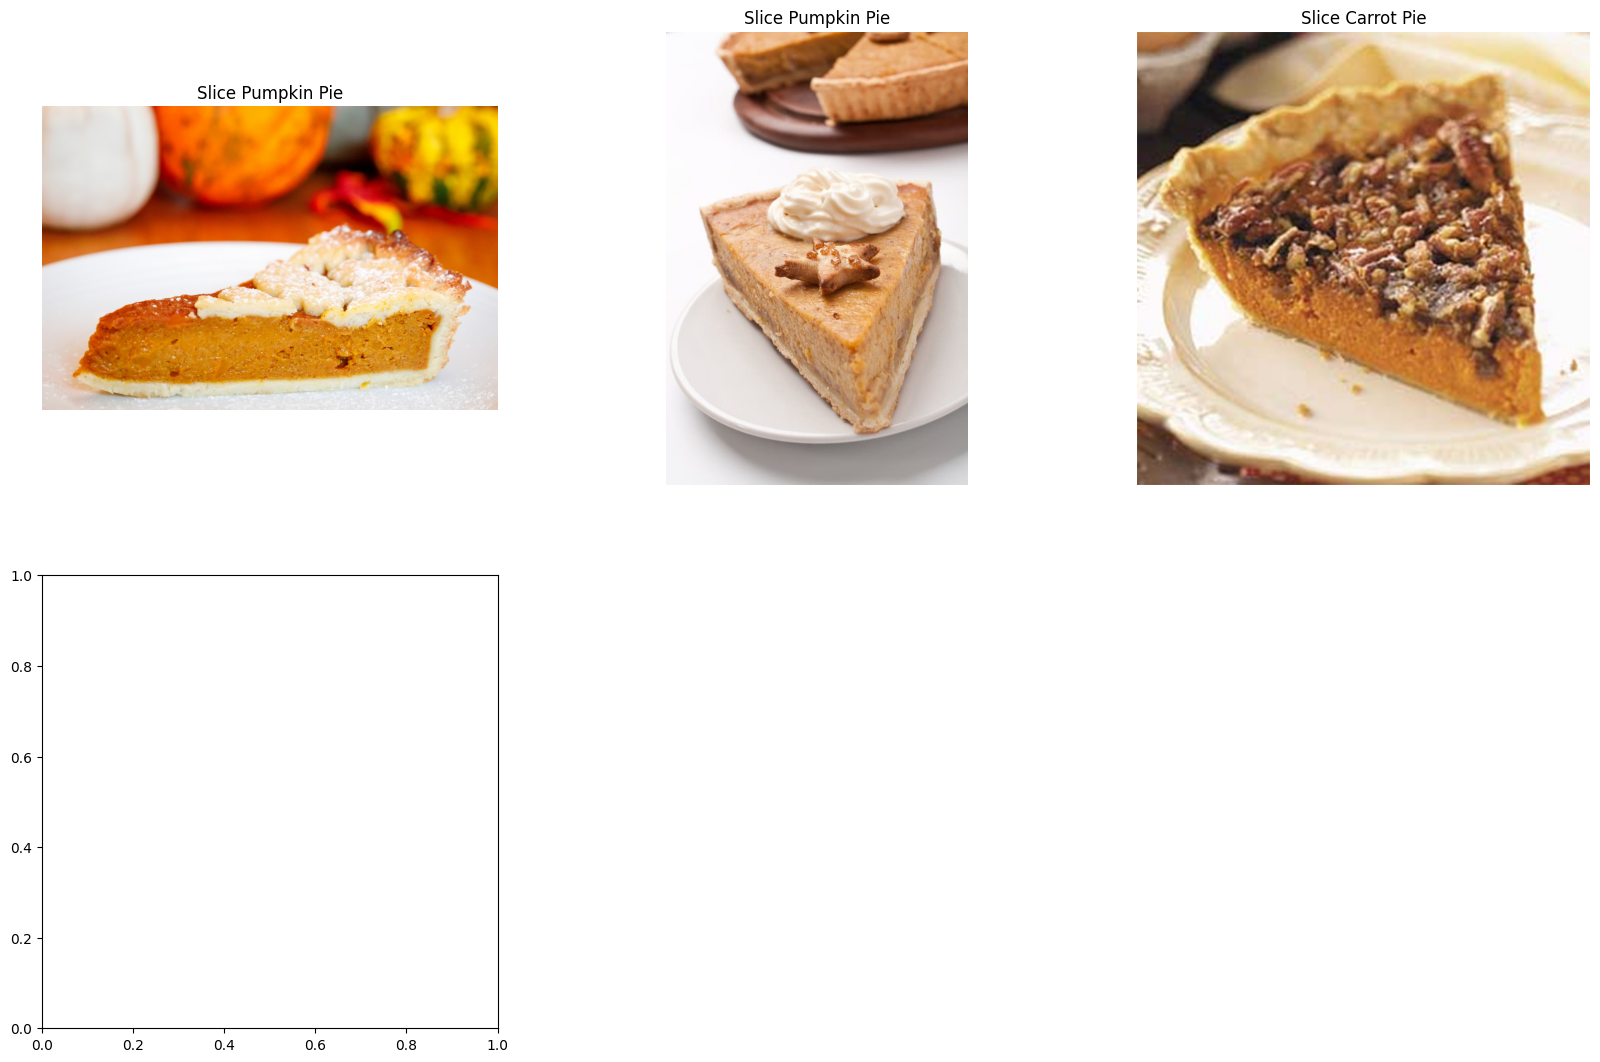

In [21]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in dataframe.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Fetch MobileNetV2 model

In [22]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False # We don't want to include the fully-connected layers
)

In [23]:
# You can see the list of layers of this model
base_model.layers

[<InputLayer name=input_layer_2, built=True>,
 <Conv2D name=Conv1, built=True>,
 <BatchNormalization name=bn_Conv1, built=True>,
 <ReLU name=Conv1_relu, built=True>,
 <DepthwiseConv2D name=expanded_conv_depthwise, built=True>,
 <BatchNormalization name=expanded_conv_depthwise_BN, built=True>,
 <ReLU name=expanded_conv_depthwise_relu, built=True>,
 <Conv2D name=expanded_conv_project, built=True>,
 <BatchNormalization name=expanded_conv_project_BN, built=True>,
 <Conv2D name=block_1_expand, built=True>,
 <BatchNormalization name=block_1_expand_BN, built=True>,
 <ReLU name=block_1_expand_relu, built=True>,
 <ZeroPadding2D name=block_1_pad, built=True>,
 <DepthwiseConv2D name=block_1_depthwise, built=True>,
 <BatchNormalization name=block_1_depthwise_BN, built=True>,
 <ReLU name=block_1_depthwise_relu, built=True>,
 <Conv2D name=block_1_project, built=True>,
 <BatchNormalization name=block_1_project_BN, built=True>,
 <Conv2D name=block_2_expand, built=True>,
 <BatchNormalization name=block

In [24]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)

def get_model():
    # We want to add layers on top of the base (here MobileNetV2) model
    layers = base_model.output

    # We need to flatten
    layers = Flatten()(layers)

    layers = Dense(512, activation='relu')(layers)
    layers = Dropout(0.4)(layers)
    layers = Dense(256, activation='relu')(layers)
    layers = Dropout(0.4)(layers)


    # We must add an output layer
    output = Dense(len(QUERIES), activation='softmax')(layers) # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False
        
        
    model.compile(
      optimizer = RMSprop(),
      # Sparse categorical crossentropy is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [25]:
get_model().summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 34,505,034 (131.63 MB)

 Trainable params: 32,247,050 (123.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Cross validate model

In [26]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [27]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path).convert('RGB') as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.stack(images)

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    try:
    
        train_images = open_images(total_train_paths[train_index])    
        train_labels = total_train_labels[train_index]
    
        val_images = open_images(total_train_paths[val_index])
        val_labels = total_train_labels[val_index]
    finally:
        print("dommage")
        
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

dommage


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Sacha/HEIG/ARN05/dataset_images/Slice Pumpkin Pie/Image_39.jpg'

In [15]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


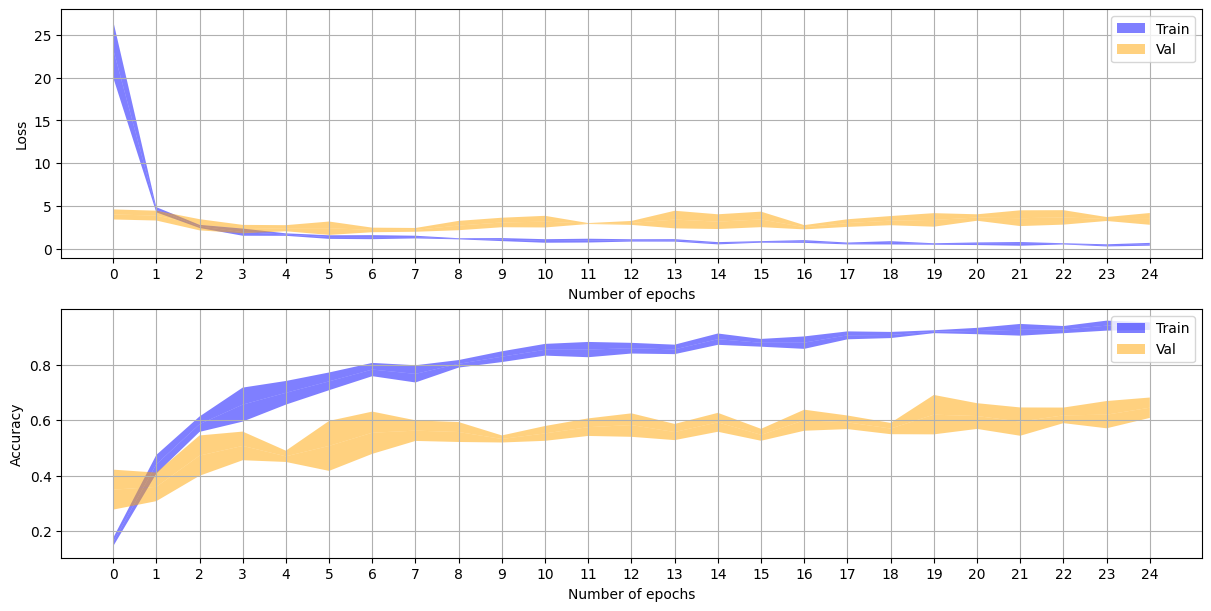

In [16]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

In [17]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - acc: 0.1271 - loss: 21.7074
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.4980 - loss: 3.3927
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.6246 - loss: 1.8450
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.6189 - loss: 1.8841
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7126 - loss: 1.1493
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.6908 - loss: 1.4216
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.7589 - loss: 1.2294
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.7793 - loss: 1.0474
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.8116 - loss: 0.9837
Epoch 10/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.8275 - loss: 0.9008
Epoch 11/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc: 0.8253 - loss: 1.1058
Epoch 12/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.7926 - loss: 1.1921
Epoch 13/25
13/13 ━━━━━━━━━━━━━━━━━

In [18]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

29208

In [19]:
import sklearn.metrics as me

test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


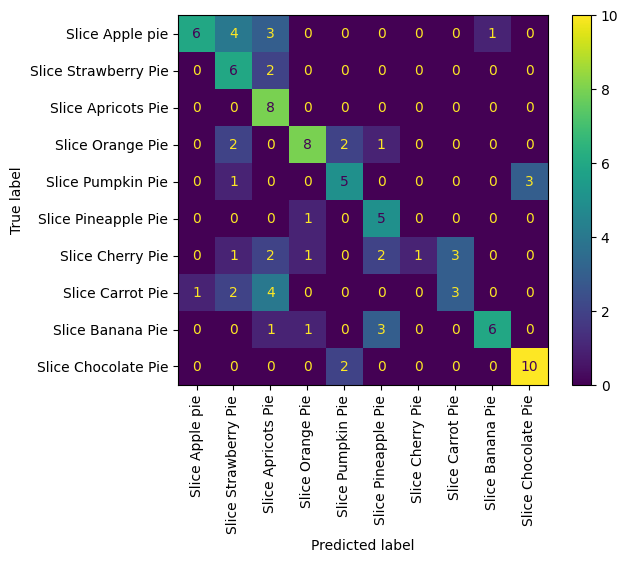

In [20]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()